# <center>Clustering Analysis<center>

<p>Team Name: Data Dredgers
<p>Student Names: Christian Bankovic, Brian Britton, Davidson Rock

## Instructions
Use generic coding style unless hard-coded values are really necessary.<br>
Your code must be efficient and use self-explanatory naming.<br>
Use appropriate Python library methods for each task instead of using loops.<br>
Run your entire code and save. Then submit this <b>saved</b> copy.

In [49]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats


## Read Data

### Explanation of Columns:

`name` (`str`): Game name for parsing HowLongToBeat
- This is Steam's name for the game, and was used to compare Steam's database to HowLongToBeat's database.

`howlongtobeat` (`str`): Most similar game name found in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`time_to_finish_h` (`str`): Time to finish a run
- How long, in hours, it takes to complete a single run.
- This is a string because some entries are `'No time registered yet'`.

`time_to_complete_h` (`str`): Time to complete 100% achievements
- How long, in hours, it takes to complete the game with 100% achievements.
- This is a string because some entries are `'No time registered yet'`.

`similarity` (`float`): Similarity relation between games name and the closest game in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`perfect_match` (`str`): Values above 0.85 are considered perfect
- This was used when comparing Steam's database to HowLongToBeat's database.
- Values are `'Exact'`, `'Non Exact'`, or `nan`.

`name_steam_games_database` (`str`): Game as found in column 1
- This is Steam's name for the game.

`appid_steam_games` (`int`): AppID from Steam Games page
- Steam's AppID.

`appid_steam` (`float`): AppID from Steam database (may differ from previous)
- Steam's... AppID?

`name_steam_database` (`str`): Games name as it is found in Steam database
- Steam's... name for the game?

`genre` (`str`): Games genre
- The genres of each game, separated by commas.

`positive_votes` (`int`): Number of positives votes

`negative_votes` (`int`): Number of negatives votes

`developer` (`str`): Games developer

`publisher` (`str`): Games Publisher to date

`tags` (`str`): Games tags
- The tags for each game, separated by commas.

`finished` (`str`): Is it 100% completed in this user account
- Whether a game is finished or is still a WIP.
- Values here are either `nan` or `'X'`.

`played_time` (`float`): Total played time
- Is this a total value or an average value??? Probably an average, maybe.

`release` (`str`): Games release date

`minimun_requirements` (`str`): PC minimun requierements
- The person typing this doesn't know how to spell, lol.

`recommended_requirements` (`str`): PC recommended requierements
- The person typing this doesn't know how to spell, lol.

`removed_game` (`str`): Is it removed from Steam store
- Values here are either `nan` or `'X'`.

`positive_rating` (`float`): Percetage of positive votes
- The person typing this doesn't know how to spell, lol.

`total_votes` (`int`): Sum of positive and negative votes

`achievements` (`str`): Does the game have achievements in it
- Values here are either `nan` or `'X'`.


<br>

---

### Columns we are using:
- `time_to_finish_h`
- `time_to_complete_h`
- `genre`
- `positive_votes`
- `negative_votes`
- `tags`
- `finished`
- `played_time`
- `removed_game`
- `positive_rating`
- `total_votes`
- `achievements`

In [50]:
# Download latest version
path = kagglehub.dataset_download("marcosparrasmolt/steam-library-metadata")
print("Path to dataset files:", path)
dataset_path = os.path.join(path, "Steam_Metadata_Full_marko_pakete.csv")
df = pd.read_csv(dataset_path)



Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\marcosparrasmolt\steam-library-metadata\versions\4


## Visual Exploration of Data

### Dataframe Cleanup

In [51]:
def normalize_minmax(df: pd.DataFrame, min: int, max: int) -> pd.DataFrame:
    #Create copy for min-max normalization
    df_norm = df.copy()
    #Normalizes filtered copy of df_norm (this function only works with int)
    for col in df_norm:
        df_norm[col] = (df_norm[col] - df_norm[col].min())/(df_norm[col].max()-df_norm[col].min())*(max-min)+min
    return df_norm

def normalize_zscore(df: pd.DataFrame) -> pd.DataFrame:
    df_norm = df.copy() 
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].mean()) / df_norm[col].std()
    return df_norm

def snip_low(df: pd.DataFrame, min: int) -> pd.DataFrame:
    df_snip = df.copy()
    for col in df_snip:
        df_snip = df_snip[df_snip[col] >= min]
    return df_snip
def snip_high(df: pd.DataFrame, max: int) -> pd.DataFrame:
    df_snip = df.copy()
    for col in df_snip:
        df_snip = df_snip[df_snip[col] <= max]
    return df_snip
def outlier_removal_IQR(df: pd.DataFrame, threshold):
    Outlier_removed_df= df.copy()
    for column in Outlier_removed_df:
        
        Q1 = Outlier_removed_df[column].quantile(0.25)
        Q3 = Outlier_removed_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        Outlier_removed_df = Outlier_removed_df[(Outlier_removed_df[column] >= lower_bound) & (Outlier_removed_df[column] <= upper_bound)]

    return Outlier_removed_df

def Z_Score_Outlier_Removal(df: pd.DataFrame, threshold): 
    Z_Score_df_clean = df.copy() 
    for column in Z_Score_df_clean: 
        z_scores = np.abs(stats.zscore(Z_Score_df_clean[column])) 
        mask = z_scores < threshold 
        Z_Score_df_clean = Z_Score_df_clean[mask] 
        return Z_Score_df_clean
    
def columnToList(df: pd.DataFrame, col: str, delimiter: str):
    df_list = df.copy()
    for i, row in df_list.iterrows():
        if (type(row[col]) == str):
            # This doesn't work because the dataframe doesn't like containing arrays with more or less than one item in them
            df_list.loc[i, col] = df_list.loc[i, col].split()
        else:
            df_list.loc[i, col] = ["None"]
    return df_list

#filter out columns we want from dataset
df_filt = df.filter(items = ['time_to_finish_h', 'time_to_complete_h', 'genre',
                             'positive_votes', 'negative_votes', 'tags', 'finished', 'played_time',
                             'removed_game', 'positive_rating', 'total_votes', 'achievements'])

#remove unwanted values from some columns
df_filt = df_filt[df_filt ['time_to_finish_h']  != 'No time registered yet']
df_filt = df_filt[df_filt['time_to_complete_h'] != 'No time registered yet']

#Change NA/NAN values to 0
df_filt = df_filt.fillna(0)

#Convert number strings to int
df_filt['time_to_finish_h'] = df_filt['time_to_finish_h'].apply(lambda x: int(x))
df_filt['time_to_complete_h'] = df_filt['time_to_complete_h'].apply(lambda x: int(x))

#Replace 'X' (meaning true) with 1
df_filt = df_filt.replace('X', 1)

#Change the categorical data into lists (WIP, broken)
# df_filt = columnToList(df_filt, 'tags', ',')

#Filter out columns that have names of genres and tags until figure out what to do with them
df_filt_exclude_col_w_string = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h',
                                      'positive_votes', 'negative_votes',  'finished', 'played_time',
                                      'removed_game', 'positive_rating', 'total_votes', 'achievements'])

df_filt_copy_for_norm = normalize_minmax(df_filt_exclude_col_w_string,0,1)

df_filt['tags']

C:\Users\chris\AppData\Local\Temp\ipykernel_14724\2163000310.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filt = df_filt.replace('X', 1)


0       Open World, Action, Multiplayer, Crime, Automo...
1       RPG, Adventure, JRPG, Exploration, 3D, Cartoon...
2       Souls-like, Dark Fantasy, RPG, Open World, Dif...
3       Co-op, Multiplayer, Action, Open World, RPG, T...
4       Co-op, Action, FPS, Heist, Looter Shooter, Mul...
                              ...                        
3168                                                    0
3169                                                    0
3170    Free to Play, Adventure, Visual Novel, Otome, ...
3171    Action, RPG, Adventure, Action RPG, Party-Base...
3172                                           RPG, Anime
Name: tags, Length: 2727, dtype: object

### Histograms

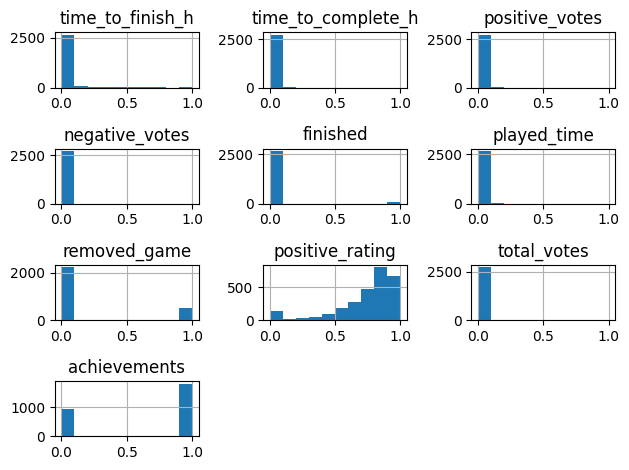

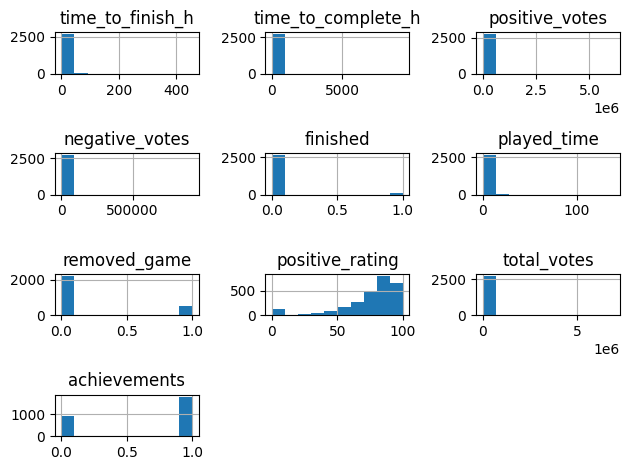

In [52]:
#Plots histogram with normalized data    
hist_norm = df_filt_copy_for_norm.hist(bins = 10)
plt.tight_layout()

#plot histogram with non-normalized data
hist = df_filt.hist(bins = 10)
plt.tight_layout()

### Distributions

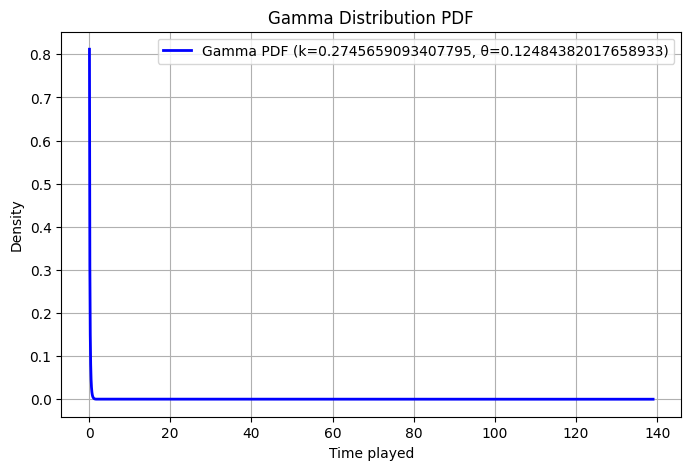

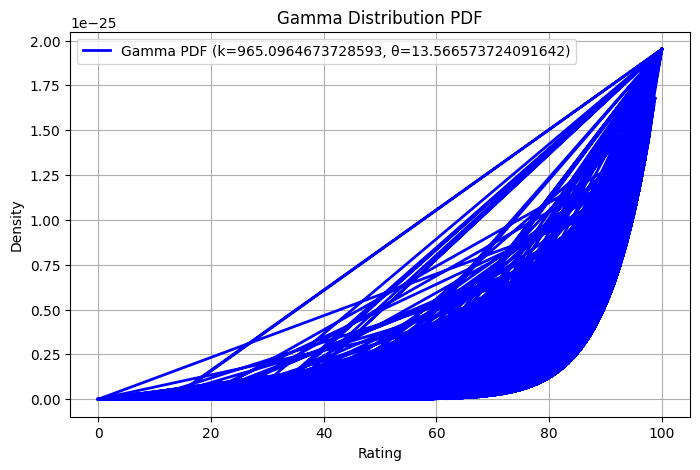

In [53]:
played_time_avg = df["played_time"].sum()/3173
rating_avg = df["positive_rating"].sum()/3173
var_played = np.var(df["played_time"])
var_rating = np.var(df["positive_rating"])
lam_played = played_time_avg**2 / var_played
lam_rating = rating_avg**2 / var_rating


#played time plot
k_played = played_time_avg * lam_played
x = df["played_time"]
pdf = scipy.stats.gamma.pdf(x, a = lam_played, scale = k_played)
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, 'b-', lw=2, label=f'Gamma PDF (k={k_played}, θ={lam_played})')
plt.title('Gamma Distribution PDF')
plt.xlabel('Time played')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#rating plot
#I think something is wrong with this but not sure
k_rating = rating_avg * lam_rating
y = df["positive_rating"]
pdf2 = scipy.stats.gamma.pdf(y, a = lam_rating, scale = k_rating)
plt.figure(figsize=(8, 5))
plt.plot(y, pdf2, 'b-', lw=2, label=f'Gamma PDF (k={k_rating}, θ={lam_rating})')
plt.title('Gamma Distribution PDF')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
#data = np.random.poisson(lam=317, size=3173)
#sns.histplot(data, kde=True)
#plt.title("Poisson Distribution Visualization")
#plt.xlabel("Number of Events")
#plt.ylabel("Frequency")
#plt.show()

Box-Whisker Plots

C:\Users\chris\AppData\Local\Temp\ipykernel_14724\1388854760.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_filt_boxplot.columns, rotation=45, ha='right')


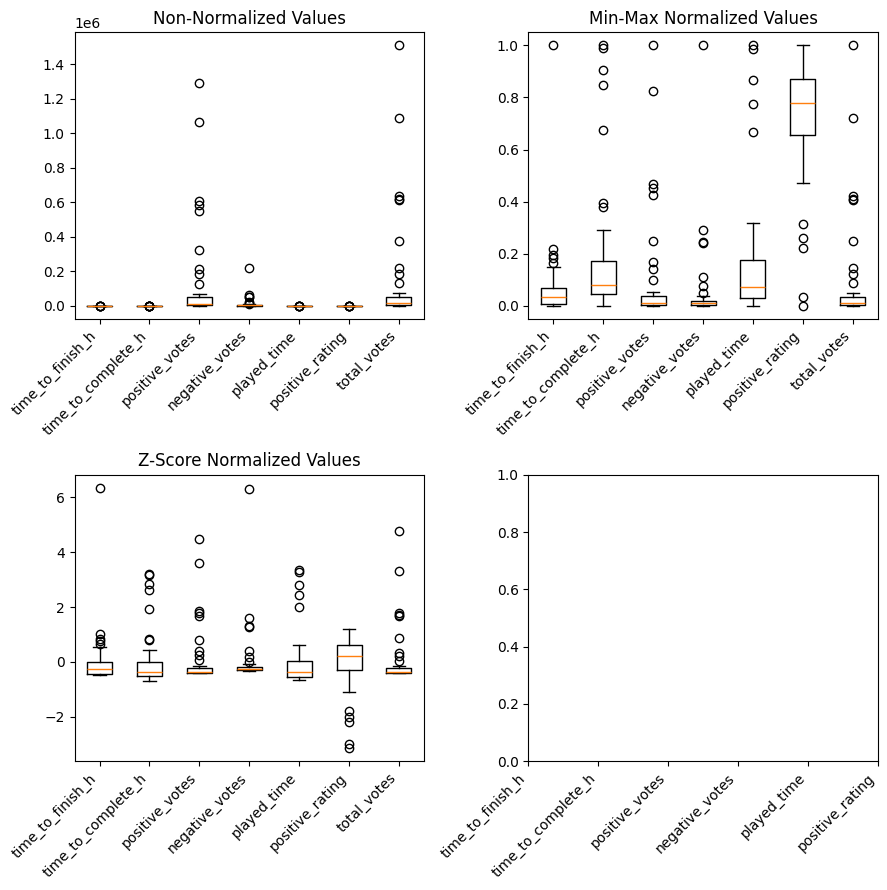

In [54]:
df_filt_boxplot = df_filt.filter(items=['time_to_finish_h', 'time_to_complete_h',
                                      'positive_votes', 'negative_votes', 'played_time',
                                      'positive_rating', 'total_votes'])
df_filt_boxplot_time_to = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h'])
df_filt_boxplot = snip_low(df_filt_boxplot,10) # clip the 0 values causing bias
df_filt_boxplot_normalized_minmax = normalize_minmax(df_filt_boxplot,0,1)
df_filt_boxplot_normalized_zscore = normalize_zscore(df_filt_boxplot)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))


#Plots boxplot with non-normalized data (not useful)
axs[0][0].boxplot(df_filt_boxplot)
axs[0][0].set_title("Non-Normalized Values")


#Plots boxplot with min-max normalized data
axs[0][1].boxplot(df_filt_boxplot_normalized_minmax)
axs[0][1].set_title("Min-Max Normalized Values")

#Plots boxplot with z-score normalized data
axs[1][0].boxplot(df_filt_boxplot_normalized_zscore)
axs[1][0].set_title("Z-Score Normalized Values")

#Format graphs
for subaxs in axs:
    for ax in subaxs:
        ax.set_xticklabels(df_filt_boxplot.columns, rotation=45, ha='right')

plt.tight_layout()


### Violin Plots

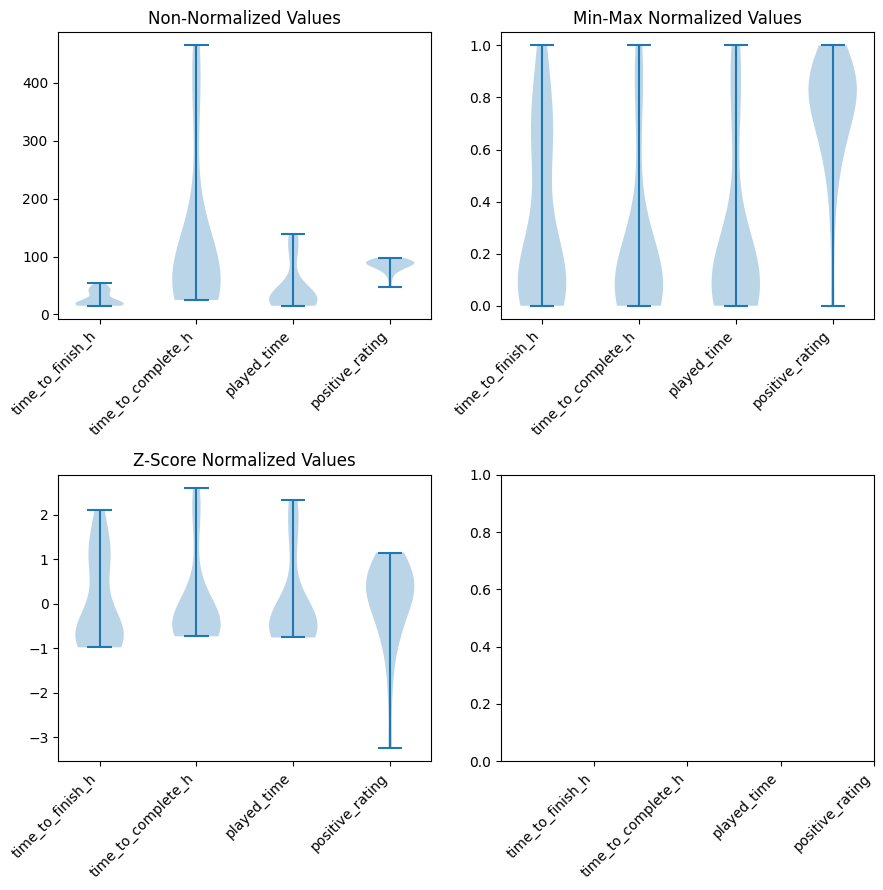

In [55]:
df_filt_violinplot = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h', 'played_time', 'positive_rating'])
df_filt_violinplot = snip_low(df_filt_violinplot,15) # clip the 0 values causing bias
df_filt_violinplot_normalized_minmax = normalize_minmax(df_filt_violinplot,0,1)
df_filt_violinplot_normalized_zscore = normalize_zscore(df_filt_violinplot)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

#Plots voilinplot with non-normalized data
axs[0][0].violinplot(df_filt_violinplot)
axs[0][0].set_title("Non-Normalized Values")

#Plots voilinplot with min-max normalized data
axs[0][1].violinplot(df_filt_violinplot_normalized_minmax)
axs[0][1].set_title("Min-Max Normalized Values")

#Plots voilinplot with z-score normalized data
axs[1][0].violinplot(df_filt_violinplot_normalized_zscore)
axs[1][0].set_title("Z-Score Normalized Values")

#Format graphs 
for subaxs in axs:
    for ax in subaxs:
        ax.set_xticks([y + 1 for y in range(len(df_filt_violinplot.columns))],
              labels=df_filt_violinplot.columns,
              rotation=45, ha='right')

plt.tight_layout()

## Data Quality & Cleaning

Instruction: Add a comment for each method

<>:42: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:45: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:42: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:45: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\chris\AppData\Local\Temp\ipykernel_14724\918072588.py:42: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  df_copy['tags'] = df_copy['tags'].str.split(',\s*')  # split by comma and optional space
C:\Users\chris\AppData\Local\Temp\ipykernel_14724\918072588.py:45: SyntaxWarnin

,name,time_to_finish_h,time_to_complete_h,genre,positive_votes,negative_votes,developer,publisher,tags,finished,played_time,release,removed_game,positive_rating,total_votes,achievements
0,Counter-Strike: Global Offensive,55,773,"[Action, Free to Play]",6121597,804720,"Valve, Hidden Path Entertainment",Valve,"[FPS, Shooter, Multiplayer, Competitive, Actio...",0,5.0,21-Aug-2012,0,88.4,6926317,1
1,Grand Theft Auto V,32,81,"[Action, Adventure]",1291158,217658,Rockstar North,Rockstar Games,"[Open World, Action, Multiplayer, Crime, Autom...",0,139.0,13-Apr-2015,0,85.6,1508816,1
2,Terraria,50,183,"[Action, Adventure, Indie, RPG]",1063429,23879,Re-Logic,Re-Logic,"[Open World Survival Craft, Sandbox, Survival,...",0,15.3,16-May-2011,0,97.8,1087308,1
3,Garry's Mod,54,595,"[Indie, Simulation]",897377,30981,Facepunch Studios,Valve,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",0,4.0,29-Nov-2006,0,96.7,928358,1
4,Rust,23,104,"[Action, Adventure, Indie, Massively Multiplay...",770797,116417,Facepunch Studios,Facepunch Studios,"[Survival, Crafting, Multiplayer, Open World, ...",0,1.8,08-Feb-2018,0,86.9,887214,1
5,Left 4 Dead 2,10,55,[Action],690135,17606,Valve,Valve,"[Zombies, Co-op, FPS, Multiplayer, Shooter, Ac...",0,9.5,16-Nov-2009,0,97.5,707741,1
6,Among Us,9,22,[Casual],600614,53583,Innersloth,Innersloth,"[Multiplayer, Online Co-Op, Social Deduction, ...",0,0.2,16-Nov-2018,0,91.8,654197,1
7,ELDEN RING,55,133,"[Action, RPG]",584246,53644,FromSoftware Inc.,"FromSoftware Inc., Bandai Namco Entertainment","[Souls-like, Dark Fantasy, RPG, Open World, Di...",1,122.0,24-Feb-2022,0,91.6,637890,1
8,Euro Truck Simulator 2,44,422,"[Indie, Simulation]",605018,16175,SCS Software,SCS Software,"[Driving, Transportation, Simulation, Open Wor...",0,16.0,12-Oct-2012,0,97.4,621193,1
9,PAYDAY 2,25,465,"[Action, RPG]",548406,63552,OVERKILL - a Starbreeze Studio.,Starbreeze Publishing AB,"[Co-op, Action, FPS, Heist, Looter Shooter, Mu...",0,96.0,13-Aug-2013,0,89.6,611958,1


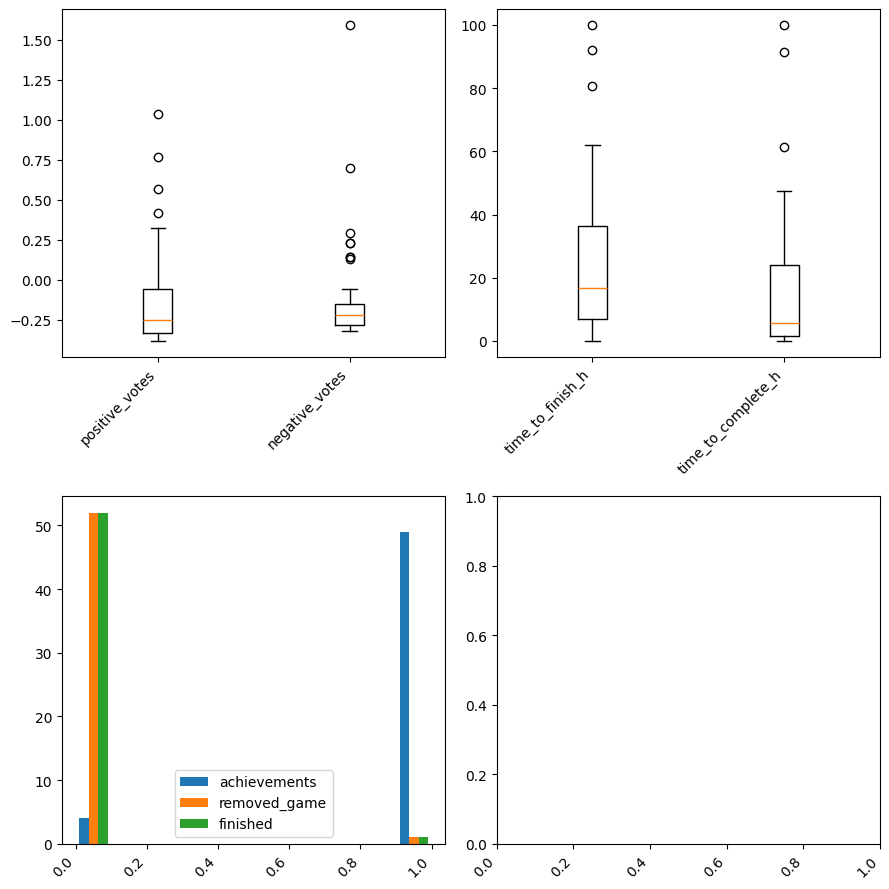

In [ ]:
# Create copy for cleanup
df_copy = df.copy()
# Filter for columns we want to focus on
df_copy = df_copy.drop(["appid_steam_games", "appid_steam", "howlongtobeat", "similarity", "perfect_match", "name_steam_games_database", "name_steam_database", "minimun_requirements", "recommended_requirements"], axis=1)
# Remove bad data
df_copy = df_copy[df_copy ['time_to_finish_h']  != 'No time registered yet']
df_copy = df_copy[df_copy ['time_to_complete_h']  != 'No time registered yet']
# Fill missing values
df_copy = df_copy.fillna(0)
# Convert string values to integers
df_copy['time_to_finish_h'] = df_copy['time_to_finish_h'].apply(lambda x: int(x))
df_copy['time_to_complete_h'] = df_copy['time_to_complete_h'].apply(lambda x: int(x))
# Fill "True" placeholders with 1
df_copy = df_copy.replace('X', 1)

# Isolate the types of data values we want to focus on
df_copy = df_copy[df_copy["total_votes"] >= 100000]
df_copy = df_copy[df_copy["positive_rating"] >= 85]
# Create dataframe that we can normalize by removing string columns
df_copy_for_norm = df_copy.drop(['name', 'release', 'genre', 'tags', 'publisher', 'developer', 'achievements', 'removed_game', 'finished', 'positive_rating'], axis=1)
df_copy_norm_minmax = normalize_minmax(df_copy_for_norm, 0, 100)
df_copy_norm_zscore = normalize_zscore(df_copy_for_norm)


# Create a few plots so we can visualize the data metter
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
# axs[0][0].boxplot(df_copy_norm_zscore[["positive_votes", "negative_votes"]], labels=df_copy_norm_zscore[["positive_votes", "negative_votes"]].columns)
axs[0][0].boxplot(snip_high(df_copy_norm_zscore[["positive_votes", "negative_votes"]], 4), labels=df_copy_norm_zscore[["positive_votes", "negative_votes"]].columns)
axs[0][1].boxplot(df_copy_norm_minmax[["time_to_finish_h", "time_to_complete_h"]], labels=df_copy_norm_minmax[["time_to_finish_h", "time_to_complete_h"]].columns)
df_copy = df_copy.sort_values(by='total_votes', ascending=False)
df_copy = df_copy.reset_index(drop=True)
axs[1][0].hist(df_copy[["achievements", "removed_game", "finished"]], label=["achievements", "removed_game", "finished"])
axs[1][0].legend(prop={'size': 10})
for sax in axs:
    for ax in sax:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")
plt.tight_layout()

# Create genre and tag lists
df_copy['tags'] = df_copy['tags'].str.split(',\s*')  # split by comma and optional space
# for tags in df_copy['tags']:
#     print(tags)
df_copy['genre'] = df_copy['genre'].str.split(',\s*')  # split by comma and optional space
# for genre in df_copy['genre']:
#     print(genre)

# Output data table (53 games???)
df_copy

## Handling Redundancy

### X-square Test

### Correlation Analysis

### Visual Exploration (scatter-plot matrix)

## Dimensionality Reduction

### PCA

## Discretization

### Histogram of Discretized Attribute

### X-square Test of Discretized Attributes

### Visual Exploration (scatter-plot matrix) of Discretized Attributes

## Feature Selection/Generation

### Select Features

### Generate Features

# Generate Clusters

## K-means

## Hierarchical

# Evaluation of Clusters

See instructions provided in the report template

## <center> REFERENCES </center>
List resources (book, internet page, etc.) that you used to complete this challenge.

https://www.geeksforgeeks.org/python/data-normalization-with-pandas/

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html
